# **Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
from torchvision.transforms import v2
from tqdm.notebook import tqdm

import torchinfo
import optuna

import nndl.models.CNN as cnn
import nndl.models.CNNLSTM as cnnlstm
import nndl.utils as utils
import time

# **Load Data From LocalHost**

In [2]:
X_test = np.load("./project_data/X_test.npy")
y_test = np.load("./project_data/y_test.npy") - 769
person_train_valid = np.load("./project_data/person_train_valid.npy")
X_train_valid = np.load("./project_data/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("./project_data/y_train_valid.npy") - 769
person_test = np.load("./project_data/person_test.npy")

print(X_train_valid.shape)
print(X_test.shape)

print(y_train_valid)

(2115, 22, 1000)
(2115, 22, 1000)
(443, 22, 1000)
[2 3 0 ... 3 3 2]


# **Device Setup**

In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using", device)

Using cuda


# **Data Prep**

In [4]:
def data_prep(X,y,sub_sample,average,noise,channel_dropout,time_reverse):

    total_X = None
    total_y = None
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    X_max, _ = torch.max(X.view(X.size(0), X.size(1), -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    X_average = torch.mean(X.view(X.size(0), X.size(1), -1, average), axis=3)
    X_average = X_average + torch.normal(0.0, 0.5, X_average.shape)

    total_X = torch.cat((total_X, X_average), dim=0)
    total_y = torch.cat((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (torch.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = torch.cat((total_X, X_subsample), dim=0)
        print(total_y.view(-1,1).shape)
        print(y.view(-1,1).shape)
        total_y = torch.cat((total_y, y))

    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)

    if channel_dropout != 0:
        mask = (torch.rand(total_X.shape[0], total_X.shape[1]) >= channel_dropout).unsqueeze(2)
        X_dropout = mask * total_X
        total_X = torch.cat((total_X, X_dropout))
        total_y = torch.cat((total_y, total_y))

        print(f'Shape of X after channel dropout {total_X.shape}')
        print(f'Shape of Y: {total_y.shape}')

    if time_reverse != 0:
        mask = (torch.rand(total_X.shape[0]) >= time_reverse)
        X_reverse = torch.flip((total_X[mask]), [2])
        total_X = torch.cat((total_X, X_reverse))
        total_y = torch.cat((total_y, total_y[mask]))

        print(f'Shape of X after reverse {total_X.shape}')
        print(f'Shape of Y: {total_y.shape}')


    return total_X,total_y
    return total_X,total_y


def test_data_prep(X):

    total_X = None

    X = X[:,:,0:800]
    print('Shape of X after trimming:', X.shape)
    X_max, _ = torch.max(X.view(X.size(0), X.size(1), -1, 2), axis=3)

    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X

In [5]:
input_size = 22
hidden_size = 256
num_layers = 10
num_classes = 4
learning_rate = 0.001
batch_size = 200
num_epochs = 100
dropout = 0.3

folds = 10
split_seed = 1
subsample = 2
average = 2
channel_dropout = 0.2
time_reverse = 0
noise = True

X_train_valid = torch.Tensor(X_train_valid)
y_train_valid = torch.Tensor(y_train_valid)

print(f'SOME {X_train_valid.shape}')
indices = torch.randperm(X_train_valid.shape[0])
split_idx = int(X_train_valid.shape[0] * ((folds-1)/folds))
X_train, X_valid = X_train_valid[indices[:split_idx]], X_train_valid[indices[split_idx:]]
y_train, y_valid = y_train_valid[indices[:split_idx]], y_train_valid[indices[split_idx:]]
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

print('Prepping Training Data')
X_train, y_train = data_prep(X_train, y_train, subsample, average, noise, channel_dropout, time_reverse)
print('\nPrepping Validation Data')
X_valid, y_valid = data_prep(X_valid, y_valid, subsample, average, noise, channel_dropout, time_reverse)
print('\nPrepping Test Data')
X_test = test_data_prep(X_test)
print('\nFINISHED PREP\n')

print('Final shape of training set:', X_train.shape)
print('Final shape of validation set:', X_valid.shape)
print('Final shape of test set:', X_test.shape)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=True)

print(f'TRAIN_DATA {len(train_loader)}\nVALID_DATA {len(val_loader)}\nTEST_DATA {len(test_loader)}')

SOME torch.Size([2115, 22, 1000])
Prepping Training Data
Shape of X after trimming: torch.Size([1903, 22, 800])
Shape of X after maxpooling: torch.Size([1903, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([3806, 22, 400])
torch.Size([3806, 1])
torch.Size([1903, 1])
torch.Size([5709, 1])
torch.Size([1903, 1])
Shape of X after subsampling and concatenating: torch.Size([7612, 22, 400])
Shape of Y: torch.Size([7612])
Shape of X after channel dropout torch.Size([15224, 22, 400])
Shape of Y: torch.Size([15224])

Prepping Validation Data
Shape of X after trimming: torch.Size([212, 22, 800])
Shape of X after maxpooling: torch.Size([212, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([424, 22, 400])
torch.Size([424, 1])
torch.Size([212, 1])
torch.Size([636, 1])
torch.Size([212, 1])
Shape of X after subsampling and concatenating: torch.Size([848, 22, 400])
Shape of Y: torch.Size([848])
Shape of X after channel dropout torch.Size([1696, 22, 400

# **CNN**

## Find Hyperparameters

In [6]:
# time to measure exactly how much of my life i won't get back
start_time = time.time()
params = utils.learn_hyperparameters(X_train=X_train, 
                                     y_train=y_train, 
                                     X_valid=X_valid, 
                                     y_valid=y_valid, 
                                     model_name='CNN', 
                                     num_epochs=10, 
                                     trials=20)
optim_end = time.time()

[I 2024-03-11 21:56:17,000] A new study created in memory with name: no-name-b3d4085e-0882-44bf-91a3-398f14a42148


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Optimizer:                          RMSprop
        Learning Rate:                  0.004359438309762025
        Weight Decay:                   2.426698555178118e-06
        Momentum:                       0.892390821835285
    Model:                              CNN
        Dropout:                        0.6342913993001621
        (Block 1) Conv1d Kernel Size:   7
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   2
        (Block 3) Conv1d Kernel Size:   2
        Pool Kernel Size:               5
        Depth:                          200
Epoch 1


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.276, Val acc: 0.279, Val loss: 1.566
Epoch 2


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.287, Val acc: 0.319, Val loss: 1.438
Epoch 3


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.286, Val acc: 0.316, Val loss: 1.346
Epoch 4


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.304, Val acc: 0.305, Val loss: 1.360
Epoch 5


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.316, Val acc: 0.298, Val loss: 1.352
Epoch 6


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.310, Val acc: 0.340, Val loss: 1.330
Epoch 7


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.314, Val acc: 0.259, Val loss: 1.334
Epoch 8


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.317, Val acc: 0.241, Val loss: 2.346
Epoch 9


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.317, Val acc: 0.338, Val loss: 1.344
Epoch 10


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.324, Val acc: 0.360, Val loss: 1.381


[I 2024-03-11 21:58:09,802] Trial 0 finished with value: 0.3596698045730591 and parameters: {'batch_size': 64, 'optimizer_name': 'RMSprop', 'learning_rate': 0.004359438309762025, 'weight_decay': 2.426698555178118e-06, 'momentum': 0.892390821835285, 'dropout': 0.6342913993001621, 'kernel1': 7, 'kernel2': '(1, 22)', 'kernel3': 2, 'kernel4': 2, 'pool_kernel': 5, 'depth': 200, 'hidden_dims': 256}. Best is trial 0 with value: 0.3596698045730591.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Optimizer:                          RMSprop
        Learning Rate:                  0.0008959513902318335
        Weight Decay:                   7.927470378339629e-06
        Momentum:                       0.847998837085181
    Model:                              CNN
        Dropout:                        0.7679059559525352
        (Block 1) Conv1d Kernel Size:   4
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   5
        (Block 3) Conv1d Kernel Size:   3
        Pool Kernel Size:               3
        Depth:                          200
Epoch 1


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.297, Val acc: 0.325, Val loss: 1.745
Epoch 2


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.338, Val acc: 0.402, Val loss: 1.355
Epoch 3


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.378, Val acc: 0.444, Val loss: 1.157
Epoch 4


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.420, Val acc: 0.465, Val loss: 1.162
Epoch 5


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.445, Val acc: 0.500, Val loss: 1.167
Epoch 6


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.470, Val acc: 0.520, Val loss: 1.106
Epoch 7


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.496, Val acc: 0.531, Val loss: 1.009
Epoch 8


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.521, Val acc: 0.501, Val loss: 1.014
Epoch 9


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.546, Val acc: 0.508, Val loss: 1.020
Epoch 10


  0%|          | 0/119 [00:00<?, ?it/s]

[I 2024-03-11 22:00:14,288] Trial 1 finished with value: 0.5306603908538818 and parameters: {'batch_size': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0008959513902318335, 'weight_decay': 7.927470378339629e-06, 'momentum': 0.847998837085181, 'dropout': 0.7679059559525352, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 5, 'kernel4': 3, 'pool_kernel': 3, 'depth': 200, 'hidden_dims': 128}. Best is trial 1 with value: 0.5306603908538818.


Train acc: 0.572, Val acc: 0.508, Val loss: 1.030
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Optimizer:                          Adam
        Learning Rate:                  0.0009799540015817917
        Weight Decay:                   1.020055868477111e-05
    Model:                              CNN
        Dropout:                        0.5415347099666802
        (Block 1) Conv1d Kernel Size:   2
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   2
        (Block 3) Conv1d Kernel Size:   5
        Pool Kernel Size:               5
        Depth:                          25
Epoch 1


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.301, Val acc: 0.360, Val loss: 1.312
Epoch 2


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.375, Val acc: 0.435, Val loss: 1.188
Epoch 3


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.430, Val acc: 0.509, Val loss: 1.163
Epoch 4


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.466, Val acc: 0.552, Val loss: 1.125
Epoch 5


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.496, Val acc: 0.522, Val loss: 1.087
Epoch 6


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.515, Val acc: 0.554, Val loss: 1.072
Epoch 7


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.531, Val acc: 0.563, Val loss: 1.061
Epoch 8


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.553, Val acc: 0.561, Val loss: 1.025
Epoch 9


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.576, Val acc: 0.579, Val loss: 1.026
Epoch 10


  0%|          | 0/119 [00:00<?, ?it/s]

[I 2024-03-11 22:00:33,851] Trial 2 finished with value: 0.6067216992378235 and parameters: {'batch_size': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.0009799540015817917, 'weight_decay': 1.020055868477111e-05, 'momentum': 0.9268877562256762, 'dropout': 0.5415347099666802, 'kernel1': 2, 'kernel2': '(1, 22)', 'kernel3': 2, 'kernel4': 5, 'pool_kernel': 5, 'depth': 25, 'hidden_dims': 256}. Best is trial 2 with value: 0.6067216992378235.


Train acc: 0.578, Val acc: 0.607, Val loss: 1.017
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Optimizer:                          RMSprop
        Learning Rate:                  0.0005908336999579217
        Weight Decay:                   5.638334377147669e-05
        Momentum:                       0.8295209693537535
    Model:                              CNN
        Dropout:                        0.5773283580226942
        (Block 1) Conv1d Kernel Size:   8
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   7
        (Block 3) Conv1d Kernel Size:   5
        Pool Kernel Size:               2
        Depth:                          50
Epoch 1


  0%|          | 0/60 [00:00<?, ?it/s]

Train acc: 0.310, Val acc: 0.338, Val loss: 3.670
Epoch 2


  0%|          | 0/60 [00:00<?, ?it/s]

Train acc: 0.335, Val acc: 0.334, Val loss: 2.337
Epoch 3


  0%|          | 0/60 [00:00<?, ?it/s]

Train acc: 0.358, Val acc: 0.351, Val loss: 2.043
Epoch 4


  0%|          | 0/60 [00:00<?, ?it/s]

Train acc: 0.380, Val acc: 0.442, Val loss: 1.448
Epoch 5


  0%|          | 0/60 [00:00<?, ?it/s]

Train acc: 0.386, Val acc: 0.378, Val loss: 1.284
Epoch 6


  0%|          | 0/60 [00:00<?, ?it/s]

Train acc: 0.413, Val acc: 0.473, Val loss: 1.473
Epoch 7


  0%|          | 0/60 [00:00<?, ?it/s]

Train acc: 0.433, Val acc: 0.455, Val loss: 1.212
Epoch 8


  0%|          | 0/60 [00:00<?, ?it/s]

Train acc: 0.457, Val acc: 0.420, Val loss: 1.232
Epoch 9


  0%|          | 0/60 [00:00<?, ?it/s]

Train acc: 0.481, Val acc: 0.501, Val loss: 1.205
Epoch 10


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2024-03-11 22:01:07,945] Trial 3 finished with value: 0.5159198045730591 and parameters: {'batch_size': 256, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0005908336999579217, 'weight_decay': 5.638334377147669e-05, 'momentum': 0.8295209693537535, 'dropout': 0.5773283580226942, 'kernel1': 8, 'kernel2': '(1, 25)', 'kernel3': 7, 'kernel4': 5, 'pool_kernel': 2, 'depth': 50, 'hidden_dims': 64}. Best is trial 2 with value: 0.6067216992378235.


Train acc: 0.504, Val acc: 0.516, Val loss: 1.194
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Optimizer:                          NAdam
        Learning Rate:                  0.004587622700729909
        Weight Decay:                   0.00012401458359715504
    Model:                              CNN
        Dropout:                        0.42256358550359785
        (Block 1) Conv1d Kernel Size:   7
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   3
        (Block 3) Conv1d Kernel Size:   2
        Pool Kernel Size:               3
        Depth:                          100
Epoch 1


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.346, Val acc: 0.320, Val loss: 2.078
Epoch 2


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.440, Val acc: 0.455, Val loss: 1.263
Epoch 3


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.552, Val acc: 0.517, Val loss: 0.870
Epoch 4


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.663, Val acc: 0.542, Val loss: 0.994
Epoch 5


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.749, Val acc: 0.588, Val loss: 1.146
Epoch 6


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.805, Val acc: 0.565, Val loss: 1.215
Epoch 7


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.842, Val acc: 0.537, Val loss: 1.241
Epoch 8


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.872, Val acc: 0.560, Val loss: 1.439
Epoch 9


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.883, Val acc: 0.543, Val loss: 1.683
Epoch 10


  0%|          | 0/119 [00:00<?, ?it/s]

[I 2024-03-11 22:01:53,215] Trial 4 finished with value: 0.588443398475647 and parameters: {'batch_size': 128, 'optimizer_name': 'NAdam', 'learning_rate': 0.004587622700729909, 'weight_decay': 0.00012401458359715504, 'momentum': 0.8030909986685252, 'dropout': 0.42256358550359785, 'kernel1': 7, 'kernel2': '(1, 17)', 'kernel3': 3, 'kernel4': 2, 'pool_kernel': 3, 'depth': 100, 'hidden_dims': 256}. Best is trial 2 with value: 0.6067216992378235.


Train acc: 0.901, Val acc: 0.569, Val loss: 1.332
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Optimizer:                          RMSprop
        Learning Rate:                  0.00010099578637633897
        Weight Decay:                   0.0038563837774613636
        Momentum:                       0.8408916584715671
    Model:                              CNN
        Dropout:                        0.47481550894834534
        (Block 1) Conv1d Kernel Size:   4
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   4
        (Block 3) Conv1d Kernel Size:   4
        Pool Kernel Size:               4
        Depth:                          200
Epoch 1


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.495, Val acc: 0.568, Val loss: 0.810
Epoch 2


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.682, Val acc: 0.583, Val loss: 0.920
Epoch 3


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.773, Val acc: 0.585, Val loss: 0.919
Epoch 4


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.825, Val acc: 0.590, Val loss: 1.081
Epoch 5


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.852, Val acc: 0.630, Val loss: 0.844
Epoch 6


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.874, Val acc: 0.612, Val loss: 1.237
Epoch 7


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.889, Val acc: 0.574, Val loss: 1.432
Epoch 8


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.888, Val acc: 0.561, Val loss: 1.155
Epoch 9


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.900, Val acc: 0.573, Val loss: 1.233
Epoch 10


  0%|          | 0/238 [00:00<?, ?it/s]

[I 2024-03-11 22:04:15,794] Trial 5 finished with value: 0.630306601524353 and parameters: {'batch_size': 64, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00010099578637633897, 'weight_decay': 0.0038563837774613636, 'momentum': 0.8408916584715671, 'dropout': 0.47481550894834534, 'kernel1': 4, 'kernel2': '(1, 25)', 'kernel3': 4, 'kernel4': 4, 'pool_kernel': 4, 'depth': 200, 'hidden_dims': 256}. Best is trial 5 with value: 0.630306601524353.


Train acc: 0.894, Val acc: 0.581, Val loss: 1.050
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Optimizer:                          Adamax
        Learning Rate:                  0.0014062837887866503
        Weight Decay:                   8.94261877449253e-05
    Model:                              CNN
        Dropout:                        0.4049029980492527
        (Block 1) Conv1d Kernel Size:   10
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   7
        (Block 3) Conv1d Kernel Size:   3
        Pool Kernel Size:               4
        Depth:                          150
Epoch 1


  0%|          | 0/60 [00:00<?, ?it/s]

Train acc: 0.403, Val acc: 0.484, Val loss: 1.193
Epoch 2


  0%|          | 0/60 [00:00<?, ?it/s]

Train acc: 0.570, Val acc: 0.494, Val loss: 1.220
Epoch 3


  0%|          | 0/60 [00:00<?, ?it/s]

Train acc: 0.660, Val acc: 0.538, Val loss: 1.159
Epoch 4


  0%|          | 0/60 [00:00<?, ?it/s]

Train acc: 0.743, Val acc: 0.547, Val loss: 1.200
Epoch 5


  0%|          | 0/60 [00:00<?, ?it/s]

Train acc: 0.816, Val acc: 0.579, Val loss: 1.220
Epoch 6


  0%|          | 0/60 [00:00<?, ?it/s]

Train acc: 0.873, Val acc: 0.584, Val loss: 1.212
Epoch 7


  0%|          | 0/60 [00:00<?, ?it/s]

Train acc: 0.911, Val acc: 0.538, Val loss: 1.415
Epoch 8


  0%|          | 0/60 [00:00<?, ?it/s]

Train acc: 0.933, Val acc: 0.561, Val loss: 1.400
Epoch 9


  0%|          | 0/60 [00:00<?, ?it/s]

Train acc: 0.948, Val acc: 0.515, Val loss: 1.585
Epoch 10


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2024-03-11 22:05:47,525] Trial 6 finished with value: 0.5837264060974121 and parameters: {'batch_size': 256, 'optimizer_name': 'Adamax', 'learning_rate': 0.0014062837887866503, 'weight_decay': 8.94261877449253e-05, 'momentum': 0.8464517926800744, 'dropout': 0.4049029980492527, 'kernel1': 10, 'kernel2': '(1, 22)', 'kernel3': 7, 'kernel4': 3, 'pool_kernel': 4, 'depth': 150, 'hidden_dims': 16}. Best is trial 5 with value: 0.630306601524353.


Train acc: 0.959, Val acc: 0.547, Val loss: 1.475
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Optimizer:                          Adamax
        Learning Rate:                  0.0001913096836040047
        Weight Decay:                   4.092437164840602e-05
    Model:                              CNN
        Dropout:                        0.4091201290646109
        (Block 1) Conv1d Kernel Size:   7
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   3
        (Block 3) Conv1d Kernel Size:   7
        Pool Kernel Size:               2
        Depth:                          150
Epoch 1


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.469, Val acc: 0.526, Val loss: 1.173
Epoch 2


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.629, Val acc: 0.575, Val loss: 1.054
Epoch 3


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.710, Val acc: 0.551, Val loss: 1.126
Epoch 4


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.784, Val acc: 0.574, Val loss: 1.154
Epoch 5


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.832, Val acc: 0.573, Val loss: 1.313
Epoch 6


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.883, Val acc: 0.568, Val loss: 1.351
Epoch 7


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.914, Val acc: 0.581, Val loss: 1.489
Epoch 8


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.933, Val acc: 0.594, Val loss: 1.396
Epoch 9


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.582, Val loss: 1.499
Epoch 10


  0%|          | 0/238 [00:00<?, ?it/s]

[I 2024-03-11 22:08:06,225] Trial 7 finished with value: 0.5943396091461182 and parameters: {'batch_size': 64, 'optimizer_name': 'Adamax', 'learning_rate': 0.0001913096836040047, 'weight_decay': 4.092437164840602e-05, 'momentum': 0.9484704452060582, 'dropout': 0.4091201290646109, 'kernel1': 7, 'kernel2': '(1, 25)', 'kernel3': 3, 'kernel4': 7, 'pool_kernel': 2, 'depth': 150, 'hidden_dims': 128}. Best is trial 5 with value: 0.630306601524353.


Train acc: 0.964, Val acc: 0.564, Val loss: 1.696
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Optimizer:                          RMSprop
        Learning Rate:                  0.004139743713569298
        Weight Decay:                   4.101304771706466e-06
        Momentum:                       0.8777931335487212
    Model:                              CNN
        Dropout:                        0.5424845689285216
        (Block 1) Conv1d Kernel Size:   7
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   4
        (Block 3) Conv1d Kernel Size:   7
        Pool Kernel Size:               2
        Depth:                          100
Epoch 1


  0%|          | 0/238 [00:00<?, ?it/s]

[I 2024-03-11 22:08:15,066] Trial 8 pruned. 


Train acc: 0.282, Val acc: 0.272, Val loss: 2.439
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Optimizer:                          Adam
        Learning Rate:                  0.0001582003259744815
        Weight Decay:                   0.00016949813959084937
    Model:                              CNN
        Dropout:                        0.6309827935861883
        (Block 1) Conv1d Kernel Size:   6
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   5
        Pool Kernel Size:               5
        Depth:                          50
Epoch 1


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2024-03-11 22:08:17,200] Trial 9 pruned. 


Train acc: 0.258, Val acc: 0.274, Val loss: 1.391
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Optimizer:                          SGD
        Learning Rate:                  0.00011022845718196509
        Weight Decay:                   0.008815248226611302
        Momentum:                       0.9766662896065499
    Model:                              CNN
        Dropout:                        0.4860514226081898
        (Block 1) Conv1d Kernel Size:   2
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   5
        (Block 3) Conv1d Kernel Size:   4
        Pool Kernel Size:               4
        Depth:                          200
Epoch 1


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.326, Val acc: 0.401, Val loss: 1.234
Epoch 2


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.420, Val acc: 0.495, Val loss: 1.127
Epoch 3


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.467, Val acc: 0.488, Val loss: 1.099


[I 2024-03-11 22:08:59,218] Trial 10 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Optimizer:                          Adam
        Learning Rate:                  0.0003910476687395572
        Weight Decay:                   0.007651358739185815
    Model:                              CNN
        Dropout:                        0.4997300070132748
        (Block 1) Conv1d Kernel Size:   2
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   2
        (Block 3) Conv1d Kernel Size:   6
        Pool Kernel Size:               5
        Depth:                          25
Epoch 1


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.286, Val acc: 0.353, Val loss: 1.386
Epoch 2


  0%|          | 0/119 [00:00<?, ?it/s]

[I 2024-03-11 22:09:03,386] Trial 11 pruned. 


Train acc: 0.333, Val acc: 0.430, Val loss: 1.350
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Optimizer:                          Adam
        Learning Rate:                  0.0018395654050037634
        Weight Decay:                   0.001114941182837919
    Model:                              CNN
        Dropout:                        0.7077621225956219
        (Block 1) Conv1d Kernel Size:   4
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   3
        (Block 3) Conv1d Kernel Size:   4
        Pool Kernel Size:               4
        Depth:                          25
Epoch 1


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.291, Val acc: 0.372, Val loss: 1.321
Epoch 2


  0%|          | 0/119 [00:00<?, ?it/s]

[I 2024-03-11 22:09:07,832] Trial 12 pruned. 


Train acc: 0.353, Val acc: 0.401, Val loss: 1.270
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Optimizer:                          SGD
        Learning Rate:                  0.0003294798378419784
        Weight Decay:                   0.0008941554691132016
        Momentum:                       0.9454313952741671
    Model:                              CNN
        Dropout:                        0.48686747126024055
        (Block 1) Conv1d Kernel Size:   4
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   4
        (Block 3) Conv1d Kernel Size:   6
        Pool Kernel Size:               5
        Depth:                          25
Epoch 1


  0%|          | 0/119 [00:00<?, ?it/s]

[I 2024-03-11 22:09:10,118] Trial 13 pruned. 


Train acc: 0.262, Val acc: 0.261, Val loss: 1.380
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Optimizer:                          NAdam
        Learning Rate:                  0.0022457360655697488
        Weight Decay:                   1.605324250924855e-05
    Model:                              CNN
        Dropout:                        0.5531196528249782
        (Block 1) Conv1d Kernel Size:   3
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   2
        (Block 3) Conv1d Kernel Size:   4
        Pool Kernel Size:               4
        Depth:                          25
Epoch 1


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.343, Val acc: 0.415, Val loss: 1.298
Epoch 2


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.431, Val acc: 0.482, Val loss: 1.286
Epoch 3


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.475, Val acc: 0.577, Val loss: 1.029
Epoch 4


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.515, Val acc: 0.550, Val loss: 1.056
Epoch 5


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.541, Val acc: 0.583, Val loss: 0.993
Epoch 6


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.565, Val acc: 0.517, Val loss: 1.241
Epoch 7


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.587, Val acc: 0.584, Val loss: 1.059
Epoch 8


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.608, Val acc: 0.580, Val loss: 0.961
Epoch 9


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.610, Val acc: 0.583, Val loss: 1.095
Epoch 10


  0%|          | 0/238 [00:00<?, ?it/s]

[I 2024-03-11 22:09:43,379] Trial 14 finished with value: 0.5837264060974121 and parameters: {'batch_size': 64, 'optimizer_name': 'NAdam', 'learning_rate': 0.0022457360655697488, 'weight_decay': 1.605324250924855e-05, 'momentum': 0.8060999945262289, 'dropout': 0.5531196528249782, 'kernel1': 3, 'kernel2': '(1, 17)', 'kernel3': 2, 'kernel4': 4, 'pool_kernel': 4, 'depth': 25, 'hidden_dims': 64}. Best is trial 5 with value: 0.630306601524353.


Train acc: 0.630, Val acc: 0.577, Val loss: 1.045
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Optimizer:                          Adam
        Learning Rate:                  0.0002877801071039551
        Weight Decay:                   0.0005630044521572216
    Model:                              CNN
        Dropout:                        0.4669900070639543
        (Block 1) Conv1d Kernel Size:   5
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   4
        (Block 3) Conv1d Kernel Size:   5
        Pool Kernel Size:               3
        Depth:                          200
Epoch 1


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.484, Val acc: 0.535, Val loss: 1.162
Epoch 2


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.659, Val acc: 0.531, Val loss: 1.288
Epoch 3


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.784, Val acc: 0.553, Val loss: 1.234
Epoch 4


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.565, Val loss: 1.020
Epoch 5


  0%|          | 0/238 [00:00<?, ?it/s]

[I 2024-03-11 22:11:03,897] Trial 15 pruned. 


Train acc: 0.911, Val acc: 0.564, Val loss: 1.073
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Optimizer:                          Adam
        Learning Rate:                  0.0006843538715973461
        Weight Decay:                   1.3904457194232056e-06
    Model:                              CNN
        Dropout:                        0.5325964967790006
        (Block 1) Conv1d Kernel Size:   3
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   3
        Pool Kernel Size:               5
        Depth:                          200
Epoch 1


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.381, Val acc: 0.517, Val loss: 1.154
Epoch 2


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.543, Val acc: 0.598, Val loss: 0.921
Epoch 3


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.646, Val acc: 0.617, Val loss: 0.955
Epoch 4


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.718, Val acc: 0.643, Val loss: 1.009
Epoch 5


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.764, Val acc: 0.651, Val loss: 0.961
Epoch 6


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.817, Val acc: 0.651, Val loss: 0.872
Epoch 7


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.850, Val acc: 0.631, Val loss: 1.042
Epoch 8


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.618, Val loss: 1.184
Epoch 9


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.903, Val acc: 0.616, Val loss: 1.188
Epoch 10


  0%|          | 0/119 [00:00<?, ?it/s]

[I 2024-03-11 22:13:06,185] Trial 16 finished with value: 0.650943398475647 and parameters: {'batch_size': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.0006843538715973461, 'weight_decay': 1.3904457194232056e-06, 'momentum': 0.9699307303334106, 'dropout': 0.5325964967790006, 'kernel1': 3, 'kernel2': '(1, 22)', 'kernel3': 6, 'kernel4': 3, 'pool_kernel': 5, 'depth': 200, 'hidden_dims': 256}. Best is trial 16 with value: 0.650943398475647.


Train acc: 0.913, Val acc: 0.601, Val loss: 1.369
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Optimizer:                          RMSprop
        Learning Rate:                  0.0005750303629840532
        Weight Decay:                   1.2633853091690697e-06
        Momentum:                       0.9749560842276771
    Model:                              CNN
        Dropout:                        0.6139382138204155
        (Block 1) Conv1d Kernel Size:   5
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   3
        Pool Kernel Size:               4
        Depth:                          200
Epoch 1


  0%|          | 0/119 [00:00<?, ?it/s]

[I 2024-03-11 22:13:19,333] Trial 17 pruned. 


Train acc: 0.277, Val acc: 0.338, Val loss: 1.512
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Optimizer:                          SGD
        Learning Rate:                  0.006901097218044314
        Weight Decay:                   0.0016379461522439233
        Momentum:                       0.8516025568820531
    Model:                              CNN
        Dropout:                        0.6884782115540572
        (Block 1) Conv1d Kernel Size:   3
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   3
        Pool Kernel Size:               5
        Depth:                          200
Epoch 1


  0%|          | 0/238 [00:00<?, ?it/s]

[I 2024-03-11 22:13:32,693] Trial 18 pruned. 


Train acc: 0.283, Val acc: 0.275, Val loss: 1.604
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Optimizer:                          Adamax
        Learning Rate:                  0.0001006113457613227
        Weight Decay:                   0.0027083806395202616
    Model:                              CNN
        Dropout:                        0.4555625052706776
        (Block 1) Conv1d Kernel Size:   3
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   5
        (Block 3) Conv1d Kernel Size:   2
        Pool Kernel Size:               4
        Depth:                          200
Epoch 1


  0%|          | 0/60 [00:00<?, ?it/s]

Train acc: 0.303, Val acc: 0.446, Val loss: 1.241
Epoch 2


  0%|          | 0/60 [00:00<?, ?it/s]

Train acc: 0.362, Val acc: 0.488, Val loss: 1.210
Epoch 3


  0%|          | 0/60 [00:00<?, ?it/s]

Train acc: 0.384, Val acc: 0.491, Val loss: 1.192


[I 2024-03-11 22:14:05,377] Trial 19 pruned. 


Number of finished trials: 20
Best trial:
    Validation Accuracy: 0.650943398475647
    Learned Hyperparameters
    ------------------------
    Batch Size:                         128
    Optimizer:                          Adam
        Learning Rate:                  0.0006843538715973461
        Weight Decay:                   1.3904457194232056e-06
    Model:                              CNN
        Dropout:                        0.5325964967790006
        (Block 1) Conv1d Kernel Size:   3
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   3
        Pool Kernel Size:               5
        Depth:                          200


## Model Summary

In [7]:
model = cnn.CNN(num_classes=4,
                dropout=params.get('dropout'),
                kernel1=params.get('kernel1'),
                kernel2=eval(params.get('kernel2')),
                kernel3=params.get('kernel3'),
                kernel4=params.get('kernel4'),
                pool_kernel=params.get('pool_kernel'),
                depth=params.get('depth')).to(device)


torchinfo.summary(model, input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [200, 4]                  --
├─Sequential: 1-1                        [200, 200, 398]           --
│    └─Conv1d: 2-1                       [200, 200, 398]           13,400
│    └─ReLU: 2-2                         [200, 200, 398]           --
│    └─BatchNorm1d: 2-3                  [200, 200, 398]           400
│    └─Dropout: 2-4                      [200, 200, 398]           --
├─Sequential: 1-2                        [200, 400, 1, 75]         --
│    └─Conv2d: 2-5                       [200, 400, 1, 377]        1,760,400
│    └─ELU: 2-6                          [200, 400, 1, 377]        --
│    └─BatchNorm2d: 2-7                  [200, 400, 1, 377]        800
│    └─MaxPool2d: 2-8                    [200, 400, 1, 75]         --
│    └─Dropout: 2-9                      [200, 400, 1, 75]         --
├─Sequential: 1-3                        [200, 800, 14]            --
│ 

## Training with Learned Hyperparameters

In [8]:
criterion = nn.CrossEntropyLoss()
if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'),
                                                                    momentum=params.get('momentum'))
else:
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

train_accuracies, val_accuracies = utils.train_model(model, 
                                                     criterion, 
                                                     optimizer, 
                                                     scheduler, 
                                                     train_loader=train_loader, 
                                                     val_loader=val_loader, 
                                                     num_epochs=100)

Epoch 1


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.359, Val acc: 0.469, Val loss: 1.215
Epoch 2


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.523, Val acc: 0.534, Val loss: 1.142
Epoch 3


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.610, Val acc: 0.650, Val loss: 1.014
Epoch 4


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.686, Val acc: 0.534, Val loss: 0.893
Epoch 5


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.746, Val acc: 0.619, Val loss: 0.907
Epoch 6


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.793, Val acc: 0.598, Val loss: 0.770
Epoch 7


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.818, Val acc: 0.630, Val loss: 0.919
Epoch 8


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.860, Val acc: 0.613, Val loss: 1.074
Epoch 9


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.882, Val acc: 0.630, Val loss: 0.890
Epoch 10


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.901, Val acc: 0.649, Val loss: 0.927
Epoch 11


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.905, Val acc: 0.617, Val loss: 1.363
Epoch 12


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.916, Val acc: 0.630, Val loss: 1.261
Epoch 13


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.934, Val acc: 0.624, Val loss: 1.234
Epoch 14


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.941, Val acc: 0.614, Val loss: 1.338
Epoch 15


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.948, Val acc: 0.630, Val loss: 1.352
Epoch 16


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.944, Val acc: 0.604, Val loss: 1.126
Epoch 17


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.955, Val acc: 0.637, Val loss: 1.207
Epoch 18


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.966, Val acc: 0.626, Val loss: 1.070
Epoch 19


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.624, Val loss: 1.527
Epoch 20


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.629, Val loss: 0.988
Epoch 21


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.629, Val loss: 1.201
Epoch 22


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.975, Val acc: 0.623, Val loss: 1.374
Epoch 23


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.976, Val acc: 0.629, Val loss: 1.276
Epoch 24


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.631, Val loss: 1.414
Epoch 25


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.627, Val loss: 1.684
Epoch 26


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.624, Val loss: 1.263
Epoch 27


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.620, Val loss: 1.458
Epoch 28


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.612, Val loss: 1.371
Epoch 29


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.621, Val loss: 1.172
Epoch 30


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.619, Val loss: 1.062
Epoch 31


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.618, Val loss: 1.162
Epoch 32


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.619, Val loss: 1.481
Epoch 33


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.619, Val loss: 1.495
Epoch 34


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.620, Val loss: 1.646
Epoch 35


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.617, Val loss: 1.301
Epoch 36


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.618, Val loss: 1.469
Epoch 37


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.619, Val loss: 1.185
Epoch 38


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.615, Val loss: 1.208
Epoch 39


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.617, Val loss: 1.425
Epoch 40


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.619, Val loss: 1.083
Epoch 41


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.620, Val loss: 1.662
Epoch 42


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.620, Val loss: 1.195
Epoch 43


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.619, Val loss: 0.907
Epoch 44


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.620, Val loss: 1.194
Epoch 45


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.616, Val loss: 1.601
Epoch 46


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.618, Val loss: 1.603
Epoch 47


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.619, Val loss: 1.394
Epoch 48


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.617, Val loss: 1.226
Epoch 49


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.618, Val loss: 1.232
Epoch 50


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.617, Val loss: 1.385
Epoch 51


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.620, Val loss: 1.495
Epoch 52


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.620, Val loss: 1.370
Epoch 53


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.619, Val loss: 1.364
Epoch 54


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.617, Val loss: 1.295
Epoch 55


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.618, Val loss: 1.358
Epoch 56


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.620, Val loss: 1.225
Epoch 57


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.617, Val loss: 1.003
Epoch 58


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.619, Val loss: 1.490
Epoch 59


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.620, Val loss: 1.314
Epoch 60


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.621, Val loss: 1.388
Epoch 61


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.620, Val loss: 1.299
Epoch 62


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.619, Val loss: 1.423
Epoch 63


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.621, Val loss: 1.298
Epoch 64


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.620, Val loss: 1.189
Epoch 65


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.617, Val loss: 1.782
Epoch 66


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.616, Val loss: 1.103
Epoch 67


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.621, Val loss: 1.100
Epoch 68


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.620, Val loss: 1.005
Epoch 69


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.619, Val loss: 1.190
Epoch 70


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.620, Val loss: 1.107
Epoch 71


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.619, Val loss: 1.302
Epoch 72


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.617, Val loss: 1.408
Epoch 73


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.622, Val loss: 1.399
Epoch 74


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.615, Val loss: 1.301
Epoch 75


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.617, Val loss: 1.652
Epoch 76


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.616, Val loss: 1.178
Epoch 77


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.617, Val loss: 0.943
Epoch 78


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.615, Val loss: 1.444
Epoch 79


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.617, Val loss: 1.271
Epoch 80


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.619, Val loss: 1.265
Epoch 81


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.620, Val loss: 1.349
Epoch 82


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.619, Val loss: 0.987
Epoch 83


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.617, Val loss: 1.068
Epoch 84


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.615, Val loss: 1.390
Epoch 85


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.619, Val loss: 1.327
Epoch 86


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.619, Val loss: 1.329
Epoch 87


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.615, Val loss: 1.095
Epoch 88


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.618, Val loss: 1.438
Epoch 89


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.618, Val loss: 1.403
Epoch 90


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.617, Val loss: 1.811
Epoch 91


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.619, Val loss: 1.214
Epoch 92


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.619, Val loss: 1.287
Epoch 93


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.622, Val loss: 1.490
Epoch 94


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.621, Val loss: 1.324
Epoch 95


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.617, Val loss: 1.333
Epoch 96


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.618, Val loss: 1.519
Epoch 97


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.619, Val loss: 1.275
Epoch 98


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.619, Val loss: 1.234
Epoch 99


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.620, Val loss: 1.111
Epoch 100


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.618, Val loss: 1.284


## Training and Accuracy Graph

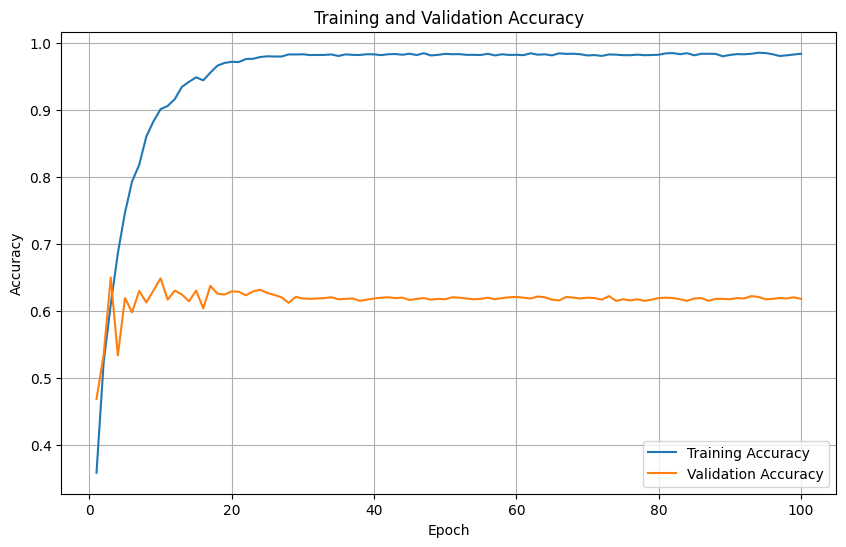

In [9]:
import matplotlib.pyplot as plt
num_epochs = 100
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

utils.test_model(model, test_loader)
end_time = time.time()

hours = (optim_end - start_time) // 3600
minutes = ((optim_end - start_time) % 3600) // 60
seconds = (optim_end - start_time) % 60

print(f'time to train hyperparameters: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

print(f'time to train model: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

Test acc: 0.641
time to train hyperparameters: 0.0 hours, 17.0 minutes, 48 seconds
time to train model: 0.0 hours, 17.0 minutes, 48 seconds


# **CNN-LSTM**

## Find Hyperparameters

In [13]:
# time to measure exactly how much of my life i won't get back
start_time = time.time()
params = utils.learn_hyperparameters(X_train=X_train, 
                                     y_train=y_train, 
                                     X_valid=X_valid, 
                                     y_valid=y_valid, 
                                     model_name='CNNLSTM', 
                                     num_epochs=10, 
                                     trials=20)
optim_end = time.time()

[I 2024-03-11 21:35:33,009] A new study created in memory with name: no-name-35051496-cbcc-4127-a8d7-7590a3426208


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Hidden Dimensions:                  16
    Optimizer:                          SGD
        Learning Rate:                  0.00931427078309344
        Weight Decay:                   1.4450073196881498e-06
        Momentum:                       0.8685584149363454
    Model:                              CNNLSTM
        Dropout:                        0.6051292026336317
        (Block 1) Conv1d Kernel Size:   3
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   4
        (Block 3) Conv1d Kernel Size:   7
        Pool Kernel Size:               2
        Depth:                          200
Epoch 1


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.260, Val acc: 0.210, Val loss: 1.408
Epoch 2


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.271, Val acc: 0.222, Val loss: 1.395
Epoch 3


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.272, Val acc: 0.211, Val loss: 1.398
Epoch 4


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.272, Val acc: 0.211, Val loss: 1.395


[I 2024-03-11 21:36:33,569] Trial 0 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Hidden Dimensions:                  256
    Optimizer:                          Adamax
        Learning Rate:                  0.003077106338438905
        Weight Decay:                   3.5258359826639886e-05
    Model:                              CNNLSTM
        Dropout:                        0.6013742178927561
        (Block 1) Conv1d Kernel Size:   9
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   4
        Pool Kernel Size:               4
        Depth:                          200
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.361, Val acc: 0.405, Val loss: 1.309
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.419, Val acc: 0.384, Val loss: 1.369
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.453, Val acc: 0.402, Val loss: 1.453
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.479, Val acc: 0.410, Val loss: 1.529
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.503, Val acc: 0.401, Val loss: 1.534
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.526, Val acc: 0.441, Val loss: 1.550
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.539, Val acc: 0.414, Val loss: 1.547
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.559, Val acc: 0.469, Val loss: 1.589
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.599, Val acc: 0.443, Val loss: 1.767
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.620, Val acc: 0.455, Val loss: 1.602


[I 2024-03-11 21:40:01,902] Trial 1 finished with value: 0.46883654594421387 and parameters: {'batch_size': 128, 'optimizer_name': 'Adamax', 'learning_rate': 0.003077106338438905, 'weight_decay': 3.5258359826639886e-05, 'momentum': 0.9068343327654902, 'dropout': 0.6013742178927561, 'kernel1': 9, 'kernel2': '(1, 25)', 'kernel3': 6, 'kernel4': 4, 'pool_kernel': 4, 'depth': 200, 'hidden_dims': 256}. Best is trial 1 with value: 0.46883654594421387.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  16
    Optimizer:                          NAdam
        Learning Rate:                  0.00012892288559441893
        Weight Decay:                   0.002786203632022915
    Model:                              CNNLSTM
        Dropout:                        0.6012470263995959
        (Block 1) Conv1d Kernel Size:   3
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   3
        (Block 3) Conv1d Kernel Size:   3
        Pool Kernel Size:               3
        Depth:                          50
Epoch 1


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.259, Val acc: 0.208, Val loss: 1.426
Epoch 2


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.262, Val acc: 0.217, Val loss: 1.428
Epoch 3


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.269, Val acc: 0.223, Val loss: 1.429
Epoch 4


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.283, Val acc: 0.234, Val loss: 1.432


[I 2024-03-11 21:40:33,287] Trial 2 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  256
    Optimizer:                          SGD
        Learning Rate:                  0.0002569037663687245
        Weight Decay:                   8.90002144119365e-06
        Momentum:                       0.9397320691772827
    Model:                              CNNLSTM
        Dropout:                        0.5749399039213628
        (Block 1) Conv1d Kernel Size:   8
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   3
        (Block 3) Conv1d Kernel Size:   5
        Pool Kernel Size:               4
        Depth:                          50
Epoch 1


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.256, Val acc: 0.257, Val loss: 1.374
Epoch 2


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.255, Val acc: 0.257, Val loss: 1.385
Epoch 3


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.256, Val acc: 0.208, Val loss: 1.395
Epoch 4


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.261, Val acc: 0.199, Val loss: 1.402


[I 2024-03-11 21:41:46,525] Trial 3 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Hidden Dimensions:                  128
    Optimizer:                          RMSprop
        Learning Rate:                  0.0009214296244905179
        Weight Decay:                   0.004823493698287639
        Momentum:                       0.8125687762624855
    Model:                              CNNLSTM
        Dropout:                        0.7920600795770457
        (Block 1) Conv1d Kernel Size:   7
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   7
        Pool Kernel Size:               3
        Depth:                          25
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.311, Val acc: 0.305, Val loss: 1.341
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.362, Val acc: 0.336, Val loss: 1.348
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.363, Val acc: 0.366, Val loss: 1.306
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.363, Val acc: 0.349, Val loss: 1.348
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.364, Val acc: 0.344, Val loss: 1.320
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.364, Val acc: 0.346, Val loss: 1.332
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.368, Val acc: 0.314, Val loss: 1.348
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.364, Val acc: 0.337, Val loss: 1.324
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.372, Val acc: 0.357, Val loss: 1.304
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.368, Val acc: 0.308, Val loss: 1.352


[I 2024-03-11 21:42:40,074] Trial 4 finished with value: 0.3656509518623352 and parameters: {'batch_size': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0009214296244905179, 'weight_decay': 0.004823493698287639, 'momentum': 0.8125687762624855, 'dropout': 0.7920600795770457, 'kernel1': 7, 'kernel2': '(1, 22)', 'kernel3': 6, 'kernel4': 7, 'pool_kernel': 3, 'depth': 25, 'hidden_dims': 128}. Best is trial 1 with value: 0.46883654594421387.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  128
    Optimizer:                          RMSprop
        Learning Rate:                  0.000638715261063614
        Weight Decay:                   0.001416294916090517
        Momentum:                       0.8017267517226312
    Model:                              CNNLSTM
        Dropout:                        0.5285374848972196
        (Block 1) Conv1d Kernel Size:   4
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   3
        Pool Kernel Size:               3
        Depth:                          100
Epoch 1


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.371, Val acc: 0.372, Val loss: 1.290
Epoch 2


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.412, Val acc: 0.397, Val loss: 1.506
Epoch 3


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.427, Val acc: 0.441, Val loss: 1.469
Epoch 4


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.438, Val acc: 0.407, Val loss: 1.446
Epoch 5


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.445, Val acc: 0.394, Val loss: 1.671
Epoch 6


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.449, Val acc: 0.404, Val loss: 1.557
Epoch 7


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.454, Val acc: 0.399, Val loss: 1.360
Epoch 8


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.453, Val acc: 0.461, Val loss: 1.395
Epoch 9


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.453, Val acc: 0.424, Val loss: 1.578
Epoch 10


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.460, Val acc: 0.445, Val loss: 1.444


[I 2024-03-11 21:44:12,072] Trial 5 finished with value: 0.46121883392333984 and parameters: {'batch_size': 64, 'optimizer_name': 'RMSprop', 'learning_rate': 0.000638715261063614, 'weight_decay': 0.001416294916090517, 'momentum': 0.8017267517226312, 'dropout': 0.5285374848972196, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 6, 'kernel4': 3, 'pool_kernel': 3, 'depth': 100, 'hidden_dims': 128}. Best is trial 1 with value: 0.46883654594421387.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Hidden Dimensions:                  256
    Optimizer:                          Adam
        Learning Rate:                  0.0018845761595771074
        Weight Decay:                   2.2102231568055607e-05
    Model:                              CNNLSTM
        Dropout:                        0.6819839066328457
        (Block 1) Conv1d Kernel Size:   8
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   4
        (Block 3) Conv1d Kernel Size:   7
        Pool Kernel Size:               5
        Depth:                          200
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.305, Val acc: 0.352, Val loss: 1.348
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.355, Val acc: 0.392, Val loss: 1.323
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.373, Val acc: 0.382, Val loss: 1.365
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.400, Val acc: 0.352, Val loss: 1.410
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.415, Val acc: 0.339, Val loss: 1.417
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.417, Val acc: 0.361, Val loss: 1.457
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.431, Val acc: 0.355, Val loss: 1.468
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.442, Val acc: 0.311, Val loss: 1.507
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.448, Val acc: 0.422, Val loss: 1.529
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.456, Val acc: 0.370, Val loss: 1.516


[I 2024-03-11 21:47:22,927] Trial 6 finished with value: 0.4217451512813568 and parameters: {'batch_size': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.0018845761595771074, 'weight_decay': 2.2102231568055607e-05, 'momentum': 0.8479311243790303, 'dropout': 0.6819839066328457, 'kernel1': 8, 'kernel2': '(1, 22)', 'kernel3': 4, 'kernel4': 7, 'pool_kernel': 5, 'depth': 200, 'hidden_dims': 256}. Best is trial 1 with value: 0.46883654594421387.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  16
    Optimizer:                          NAdam
        Learning Rate:                  0.002052434415545365
        Weight Decay:                   0.0037272993529668093
    Model:                              CNNLSTM
        Dropout:                        0.4152637317747216
        (Block 1) Conv1d Kernel Size:   4
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   2
        (Block 3) Conv1d Kernel Size:   5
        Pool Kernel Size:               4
        Depth:                          100
Epoch 1


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.350, Val acc: 0.360, Val loss: 1.134
Epoch 2


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.395, Val acc: 0.369, Val loss: 1.320
Epoch 3


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.401, Val acc: 0.368, Val loss: 1.192
Epoch 4


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.403, Val acc: 0.413, Val loss: 1.321
Epoch 5


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.408, Val acc: 0.400, Val loss: 1.293
Epoch 6


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.407, Val acc: 0.398, Val loss: 1.423
Epoch 7


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.405, Val acc: 0.376, Val loss: 1.554
Epoch 8


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.409, Val acc: 0.402, Val loss: 1.339
Epoch 9


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.411, Val acc: 0.388, Val loss: 1.205
Epoch 10


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.407, Val acc: 0.368, Val loss: 1.218


[I 2024-03-11 21:48:42,283] Trial 7 finished with value: 0.41274237632751465 and parameters: {'batch_size': 64, 'optimizer_name': 'NAdam', 'learning_rate': 0.002052434415545365, 'weight_decay': 0.0037272993529668093, 'momentum': 0.9049064744423928, 'dropout': 0.4152637317747216, 'kernel1': 4, 'kernel2': '(1, 25)', 'kernel3': 2, 'kernel4': 5, 'pool_kernel': 4, 'depth': 100, 'hidden_dims': 16}. Best is trial 1 with value: 0.46883654594421387.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Hidden Dimensions:                  32
    Optimizer:                          SGD
        Learning Rate:                  0.00064556283174242
        Weight Decay:                   0.000740121309598331
        Momentum:                       0.8565416853494617
    Model:                              CNNLSTM
        Dropout:                        0.7239137593398745
        (Block 1) Conv1d Kernel Size:   6
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   5
        Pool Kernel Size:               3
        Depth:                          150
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.250, Val acc: 0.281, Val loss: 1.372
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.255, Val acc: 0.287, Val loss: 1.373
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.249, Val acc: 0.291, Val loss: 1.378
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.250, Val acc: 0.282, Val loss: 1.382
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.256, Val acc: 0.298, Val loss: 1.382
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.252, Val acc: 0.288, Val loss: 1.387
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.257, Val acc: 0.270, Val loss: 1.390


[I 2024-03-11 21:49:48,528] Trial 8 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  128
    Optimizer:                          NAdam
        Learning Rate:                  0.001323309689916731
        Weight Decay:                   0.002754662517174508
    Model:                              CNNLSTM
        Dropout:                        0.5866497737070859
        (Block 1) Conv1d Kernel Size:   10
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   4
        Pool Kernel Size:               2
        Depth:                          25
Epoch 1


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.363, Val acc: 0.345, Val loss: 1.349
Epoch 2


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.421, Val acc: 0.370, Val loss: 1.297
Epoch 3


  0%|          | 0/405 [00:00<?, ?it/s]

[W 2024-03-11 21:50:13,318] Trial 9 failed with parameters: {'batch_size': 64, 'optimizer_name': 'NAdam', 'learning_rate': 0.001323309689916731, 'weight_decay': 0.002754662517174508, 'momentum': 0.9539975006440601, 'dropout': 0.5866497737070859, 'kernel1': 10, 'kernel2': '(1, 22)', 'kernel3': 6, 'kernel4': 4, 'pool_kernel': 2, 'depth': 25, 'hidden_dims': 128} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/warren/UCLA/W24/ECEC147/project/venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/home/warren/EEG/nndl/utils.py", line 378, in <lambda>
  File "/home/warren/EEG/nndl/utils.py", line 342, in objective
  File "/home/warren/EEG/nndl/utils.py", line 82, in train_model
    y_hat = torch.argmax(logits, dim=-1)
             ^^^^^^^^^^^^
  File "/home/warren/UCLA/W24/ECEC147/project/venv/lib/python3.11/site-packages/torch/nn/mo

KeyboardInterrupt: 

## Model Summary

In [ ]:
model = cnnlstm.CNNLSTM(num_classes=4,
                        hidden_dims=params.get('hidden_dims'),
                        dropout=params.get('dropout'),
                        kernel1=params.get('kernel1'),
                        kernel2=eval(params.get('kernel2')),
                        kernel3=params.get('kernel3'),
                        kernel4=params.get('kernel4'),
                        pool_kernel=params.get('pool_kernel'),
                        depth=params.get('depth'),
                        scale=params.get('scale')).to(device)


torchinfo.summary(model, input_size=(batch_size, 22, 400))

## Training with Learned Hyperparameters

In [ ]:
criterion = nn.CrossEntropyLoss()
if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'),
                                                                    momentum=params.get('momentum'))
else:
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

train_accuracies, val_accuracies = utils.train_model(model, 
                                                     criterion, 
                                                     optimizer, 
                                                     scheduler, 
                                                     train_loader=train_loader, 
                                                     val_loader=val_loader, 
                                                     num_epochs=100)

## Training and Accuracy Graph

In [ ]:
import matplotlib.pyplot as plt
num_epochs = 100
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

utils.test_model(model, test_loader)
end_time = time.time()

hours = (optim_end - start_time) // 3600
minutes = ((optim_end - start_time) % 3600) // 60
seconds = (optim_end - start_time) % 60

print(f'time to train hyperparameters: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

print(f'time to train model: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

In [ ]:
# given (200, 22, 400) <=> (batch_size, channels, time_bins)
class CNN(nn.Module):
  def __init__(self, num_classes):
    super(CNN, self).__init__()

    # first block: convolve over time with kernel size 3.
    # out_channels: 25
    # activation: ReLU
    # uses standard dropout of 0.5
    self.conv1 = nn.Sequential(
        nn.Conv1d(in_channels=22, out_channels=25, kernel_size=10),
        nn.ReLU(),
        nn.BatchNorm1d(25),
        nn.Dropout(0.5)
    )

    # second block: convolve over space with kernel size (1, 22) to match dims.
    #               and a stride of 2.
    # out_channels: 25 * 2 = 50
    # activation: ELU
    # pooling: Mean pooling with kernel size (1, 3)
    # uses standard dropout of 0.5
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=25, out_channels=50, kernel_size=(1, 22), stride=2),
        nn.ELU(),
        nn.BatchNorm2d(50),
        nn.AvgPool2d(kernel_size=(1, 3)),
        nn.Dropout(0.5)
    )

    # third block: convolve over time with kernel size 5.
    #               and a stride of 2.
    # out_channels: 50 * 2 = 100
    # activation: ELU
    # pooling: Mean pooling with kernel size (1, 3)
    # uses standard dropout of 0.5
    self.conv3 = nn.Sequential(
        nn.Conv1d(in_channels=50, out_channels=100, kernel_size=5),
        nn.ELU(),
        nn.BatchNorm1d(100),
        nn.AvgPool2d(kernel_size=(1, 3)),
        nn.Dropout(0.5)
    )

    # fourth block: convolve over time with kernel size 5 and a stride of 3.
    # out_channels: 100 * 2 = 200
    # activation: ELU
    # pooling: Mean pooling with kernel size (1, 3)
    # uses standard dropout of 0.5
    self.conv4 = nn.Sequential(
        nn.Conv1d(in_channels=100, out_channels=200, kernel_size=5, stride=3),
        nn.ELU(),
        nn.BatchNorm1d(200),
        nn.MaxPool2d(kernel_size=(1, 3)),
        nn.Dropout(0.5)
    )

    # dense block: fully-connected affine layer
    self.dense = nn.Linear(in_features=200, out_features=num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = x.unsqueeze(2)      # match dims for Conv2d().
    x = self.conv2(x)
    x = x.squeeze(2)        # match dims for Conv1d().
    x = self.conv3(x)
    x = self.conv4(x)
    x = torch.flatten(x, 1) # match dims for affine.
    x = self.dense(x)

    return F.log_softmax(x, dim=1)


In [ ]:
model = CNN(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate, weight_decay=5e-3)

In [ ]:
train_accuracies = []
val_accuracies = []

for epoch_idx in range(num_epochs):
    print(f'EPOCH {epoch_idx}')
    model.train() # setting model to train mode because some models behave differently when in training or evaluation (think dropout)
    train_count = 0
    train_correct_count = 0
    for batch_idx, (train_x, train_y) in enumerate(tqdm(train_loader)):
        train_x = train_x.float().to(device)
        train_y = train_y.long().to(device)

        # print(train_x.shape)
        logits = model(train_x)
        # print(logits.shape)
        loss = criterion(logits, train_y) # loss function needs logits here (look at docs)

        optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
        # sometimes useful if you want to accumulate gradients across passes (in minibatch we dont want this)
        loss.backward() # do backwards pass
        optimizer.step() # take a step using gradients

        with torch.no_grad(): # stop gradients from being tracked (used when computing arbitrary statistics)
            y_hat = torch.argmax(logits, dim=-1)
            train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            train_count += train_x.size(0)

    train_acc = train_correct_count / train_count # getting accuracy measure

    model.eval() # puts the model in eval mode
    val_count = 0
    val_correct_count = 0
    with torch.no_grad(): # dont want gradients to be computed
        for idx, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to(device)
            val_y = val_y.long().to(device)
            logits = model(val_x).detach()
            y_hat = torch.argmax(logits, dim=-1) # choose most probable class in output
            #print(f"PRED: {y_hat}")
            #print(f"ACTUAL: {val_y}")
            val_correct_count += torch.sum(y_hat == val_y, axis=-1)
            val_count += val_y.size(0)
    val_acc = val_correct_count / val_count

    train_accuracies.append(train_acc.item())
    val_accuracies.append(val_acc.item())

    print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))

EPOCH 0


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 53.18it/s]


Train acc: 0.302, Val acc: 0.425
EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.84it/s]


Train acc: 0.417, Val acc: 0.547
EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 51.22it/s]


Train acc: 0.491, Val acc: 0.547
EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.25it/s]


Train acc: 0.542, Val acc: 0.482
EPOCH 4


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.96it/s]


Train acc: 0.565, Val acc: 0.515
EPOCH 5


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.71it/s]


Train acc: 0.584, Val acc: 0.412
EPOCH 6


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.28it/s]


Train acc: 0.608, Val acc: 0.519
EPOCH 7


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.59it/s]


Train acc: 0.626, Val acc: 0.501
EPOCH 8


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.35it/s]


Train acc: 0.639, Val acc: 0.620
EPOCH 9


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.10it/s]


Train acc: 0.654, Val acc: 0.454
EPOCH 10


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.44it/s]


Train acc: 0.666, Val acc: 0.502
EPOCH 11


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.59it/s]


Train acc: 0.676, Val acc: 0.659
EPOCH 12


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.17it/s]


Train acc: 0.695, Val acc: 0.596
EPOCH 13


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 52.62it/s]


Train acc: 0.691, Val acc: 0.354
EPOCH 14


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.31it/s]


Train acc: 0.687, Val acc: 0.515
EPOCH 15


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.12it/s]


Train acc: 0.702, Val acc: 0.542
EPOCH 16


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.86it/s]


Train acc: 0.712, Val acc: 0.612
EPOCH 17


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.30it/s]


Train acc: 0.722, Val acc: 0.545
EPOCH 18


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.68it/s]


Train acc: 0.720, Val acc: 0.684
EPOCH 19


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.40it/s]


Train acc: 0.740, Val acc: 0.624
EPOCH 20


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.37it/s]


Train acc: 0.726, Val acc: 0.590
EPOCH 21


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.23it/s]


Train acc: 0.733, Val acc: 0.645
EPOCH 22


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 53.05it/s]


Train acc: 0.744, Val acc: 0.566
EPOCH 23


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.00it/s]


Train acc: 0.739, Val acc: 0.402
EPOCH 24


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 53.21it/s]


Train acc: 0.745, Val acc: 0.580
EPOCH 25


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.10it/s]


Train acc: 0.747, Val acc: 0.623
EPOCH 26


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.19it/s]


Train acc: 0.766, Val acc: 0.517
EPOCH 27


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.72it/s]


Train acc: 0.767, Val acc: 0.620
EPOCH 28


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.26it/s]


Train acc: 0.768, Val acc: 0.494
EPOCH 29


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 52.39it/s]


Train acc: 0.762, Val acc: 0.527
EPOCH 30


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 53.10it/s]


Train acc: 0.748, Val acc: 0.618
EPOCH 31


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 50.43it/s]


Train acc: 0.767, Val acc: 0.519
EPOCH 32


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.90it/s]


Train acc: 0.764, Val acc: 0.521
EPOCH 33


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.90it/s]


Train acc: 0.782, Val acc: 0.678
EPOCH 34


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.85it/s]


Train acc: 0.791, Val acc: 0.505
EPOCH 35


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.90it/s]


Train acc: 0.770, Val acc: 0.552
EPOCH 36


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.34it/s]


Train acc: 0.783, Val acc: 0.502
EPOCH 37


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.43it/s]


Train acc: 0.783, Val acc: 0.529
EPOCH 38


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.45it/s]


Train acc: 0.782, Val acc: 0.442
EPOCH 39


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.64it/s]


Train acc: 0.764, Val acc: 0.657
EPOCH 40


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 53.80it/s]


Train acc: 0.799, Val acc: 0.656
EPOCH 41


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.42it/s]


Train acc: 0.804, Val acc: 0.646
EPOCH 42


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.63it/s]


Train acc: 0.801, Val acc: 0.630
EPOCH 43


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.66it/s]


Train acc: 0.804, Val acc: 0.616
EPOCH 44


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.56it/s]


Train acc: 0.807, Val acc: 0.554
EPOCH 45


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 37.81it/s]


Train acc: 0.801, Val acc: 0.518
EPOCH 46


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.85it/s]


Train acc: 0.807, Val acc: 0.650
EPOCH 47


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.92it/s]


Train acc: 0.808, Val acc: 0.456
EPOCH 48


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 49.03it/s]


Train acc: 0.739, Val acc: 0.631
EPOCH 49


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.65it/s]


Train acc: 0.794, Val acc: 0.658
EPOCH 50


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.71it/s]


Train acc: 0.809, Val acc: 0.639
EPOCH 51


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.57it/s]


Train acc: 0.808, Val acc: 0.624
EPOCH 52


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.58it/s]


Train acc: 0.810, Val acc: 0.620
EPOCH 53


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.91it/s]


Train acc: 0.813, Val acc: 0.548
EPOCH 54


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.27it/s]


Train acc: 0.805, Val acc: 0.488
EPOCH 55


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.91it/s]


Train acc: 0.811, Val acc: 0.664
EPOCH 56


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.76it/s]


Train acc: 0.820, Val acc: 0.675
EPOCH 57


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.10it/s]


Train acc: 0.823, Val acc: 0.538
EPOCH 58


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.11it/s]


Train acc: 0.816, Val acc: 0.699
EPOCH 59


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 59.75it/s]


Train acc: 0.824, Val acc: 0.593
EPOCH 60


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.79it/s]


Train acc: 0.810, Val acc: 0.665
EPOCH 61


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.15it/s]


Train acc: 0.825, Val acc: 0.564
EPOCH 62


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.57it/s]


Train acc: 0.814, Val acc: 0.581
EPOCH 63


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.37it/s]


Train acc: 0.816, Val acc: 0.637
EPOCH 64


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.12it/s]


Train acc: 0.814, Val acc: 0.644
EPOCH 65


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.65it/s]


Train acc: 0.819, Val acc: 0.617
EPOCH 66


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.83it/s]


Train acc: 0.823, Val acc: 0.657
EPOCH 67


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.18it/s]


Train acc: 0.816, Val acc: 0.532
EPOCH 68


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.36it/s]


Train acc: 0.807, Val acc: 0.554
EPOCH 69


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.73it/s]


Train acc: 0.815, Val acc: 0.567
EPOCH 70


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.26it/s]


Train acc: 0.816, Val acc: 0.670
EPOCH 71


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.08it/s]


Train acc: 0.840, Val acc: 0.587
EPOCH 72


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.13it/s]


Train acc: 0.832, Val acc: 0.584
EPOCH 73


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.91it/s]


Train acc: 0.828, Val acc: 0.686
EPOCH 74


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.14it/s]


Train acc: 0.847, Val acc: 0.665
EPOCH 75


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.24it/s]


Train acc: 0.830, Val acc: 0.637
EPOCH 76


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.05it/s]


Train acc: 0.824, Val acc: 0.593
EPOCH 77


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.59it/s]


Train acc: 0.837, Val acc: 0.642
EPOCH 78


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.93it/s]


Train acc: 0.830, Val acc: 0.665
EPOCH 79


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.73it/s]


Train acc: 0.838, Val acc: 0.688
EPOCH 80


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.06it/s]


Train acc: 0.832, Val acc: 0.526
EPOCH 81


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.43it/s]


Train acc: 0.827, Val acc: 0.676
EPOCH 82


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.48it/s]


Train acc: 0.837, Val acc: 0.656
EPOCH 83


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.11it/s]


Train acc: 0.845, Val acc: 0.700
EPOCH 84


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.65it/s]


Train acc: 0.843, Val acc: 0.673
EPOCH 85


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.71it/s]


Train acc: 0.839, Val acc: 0.607
EPOCH 86


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.75it/s]


Train acc: 0.842, Val acc: 0.685
EPOCH 87


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.41it/s]


Train acc: 0.840, Val acc: 0.550
EPOCH 88


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 50.91it/s]


Train acc: 0.806, Val acc: 0.645
EPOCH 89


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.62it/s]


Train acc: 0.838, Val acc: 0.669
EPOCH 90


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.70it/s]


Train acc: 0.841, Val acc: 0.676
EPOCH 91


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.41it/s]


Train acc: 0.846, Val acc: 0.624
EPOCH 92


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.91it/s]


Train acc: 0.836, Val acc: 0.682
EPOCH 93


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.26it/s]


Train acc: 0.837, Val acc: 0.478
EPOCH 94


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.12it/s]


Train acc: 0.805, Val acc: 0.640
EPOCH 95


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.34it/s]


Train acc: 0.833, Val acc: 0.692
EPOCH 96


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.96it/s]


Train acc: 0.843, Val acc: 0.682
EPOCH 97


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.73it/s]


Train acc: 0.844, Val acc: 0.690
EPOCH 98


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.59it/s]


Train acc: 0.846, Val acc: 0.676
EPOCH 99


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.13it/s]

Train acc: 0.845, Val acc: 0.716


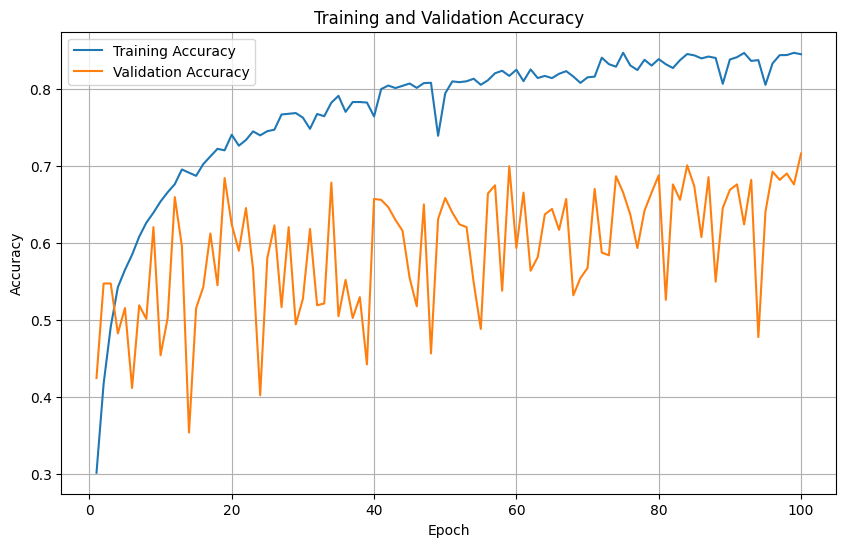

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    test_count = 0
    test_correct_count = 0
    for idx, (test_x, test_y) in enumerate(test_loader):
        test_x = test_x.float().to(device)
        test_y = test_y.long().to(device)
        logits = model(test_x).detach()
        y_hat = torch.argmax(logits, dim=-1)
        test_correct_count += torch.sum(y_hat == test_y, axis=-1)
        test_count += test_x.size(0)
    test_acc = test_correct_count / test_count
    print('Test acc: {:.3f}'.format(test_acc))

Test acc: 0.713
